In [1]:
import osmnx as ox
import geopandas as gpd
import numpy as npm
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from rtree.index import Index as RTreeIndex
from shapely.geometry import Point
from shapely.geometry import LineString
from shapely.geometry import MultiLineString
from collections import deque
import datetime
from tqdm import tqdm
import networkx as nx

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
CRS_PLOT = 'EPSG:4326'
DATA_DIR = '../data'
EXPORTS_DIR = f'{DATA_DIR}/exports'
COLUMNS = ['route', 'x', 'latitude', 'longitude', 'bus_id', 'datetime']

In [3]:
bk = ox.io.load_graphml('bk.graphml')

In [157]:
ROUTES = [
    'b3',
    'b6',
    'b8',
    'b9',
    'b11',
    'b12',
    'b16',
    'b25',
    'b26',
    'b35',
    'b37',
    'b43',
    'b44',
    'b48',
    'b52',
    'b61',
    'b63',
    'b65',
    'b68',
    'b82',
]
diff_df = pd.concat([pd.read_csv(f'{EXPORTS_DIR}/diffs/{r}_diff.csv') for r in ROUTES])

In [158]:
diff_avg_df = diff_df.median()
diff_avg_df.index = diff_avg_df.index.astype(int)
diff_avg_df = diff_avg_df.apply(lambda x: min(x, 600))
diff_avg_df = diff_avg_df.apply(lambda x: max(x, -600))

In [159]:
route_node_ids_list = []
for route in ROUTES:
    route_node_ids_df = pd.read_csv(f'{EXPORTS_DIR}/route_nodes/{route}_route_nodes.csv')
    route_node_ids = route_node_ids_df.iloc[:, 0].astype(int).tolist()
    route_node_ids_list.append(route_node_ids)

In [183]:
diff_id_set = set(diff_avg_df.index)

def create_route_subgraph(node_ids_list):
    graph = nx.MultiDiGraph()
    for node_ids in node_ids_list:
        for node_id in node_ids:
            if node_id in diff_id_set:
                node = bk.nodes[node_id]
                graph.add_node(node_id, **node)
    for node_ids in node_ids_list:
        for i in range(0, len(node_ids) - 1):
            if node_ids[i] in diff_id_set and node_ids[i + 1] in diff_id_set:
                graph.add_edge(node_ids[i], node_ids[i + 1])
    graph.graph['crs'] = CRS_PLOT
    return graph

route_subgraph = create_route_subgraph(route_node_ids_list)

for edge in route_subgraph.edges:
    route_subgraph.add_edge(edge[0], edge[1], edge[2], weight=0)
    
time_deltas = []

for route_node_ids in route_node_ids_list:
    for i in range(0, len(route_node_ids) - 1):
        route_node_id = route_node_ids[i]
        next_node_id = route_node_ids[i + 1]
        if route_node_id not in diff_avg_df.index:
            continue
        if next_node_id not in diff_avg_df.index:
            continue
        time_delta = diff_avg_df.loc[route_node_id]
        time_deltas.append(time_delta)
        if time_delta < 0:
            time_delta = 0
        route_subgraph.add_edge(route_node_id, next_node_id, 0, weight=abs(time_delta))

In [197]:
print(np.min(time_deltas))
print(np.max(time_deltas))

-320.0
239.0


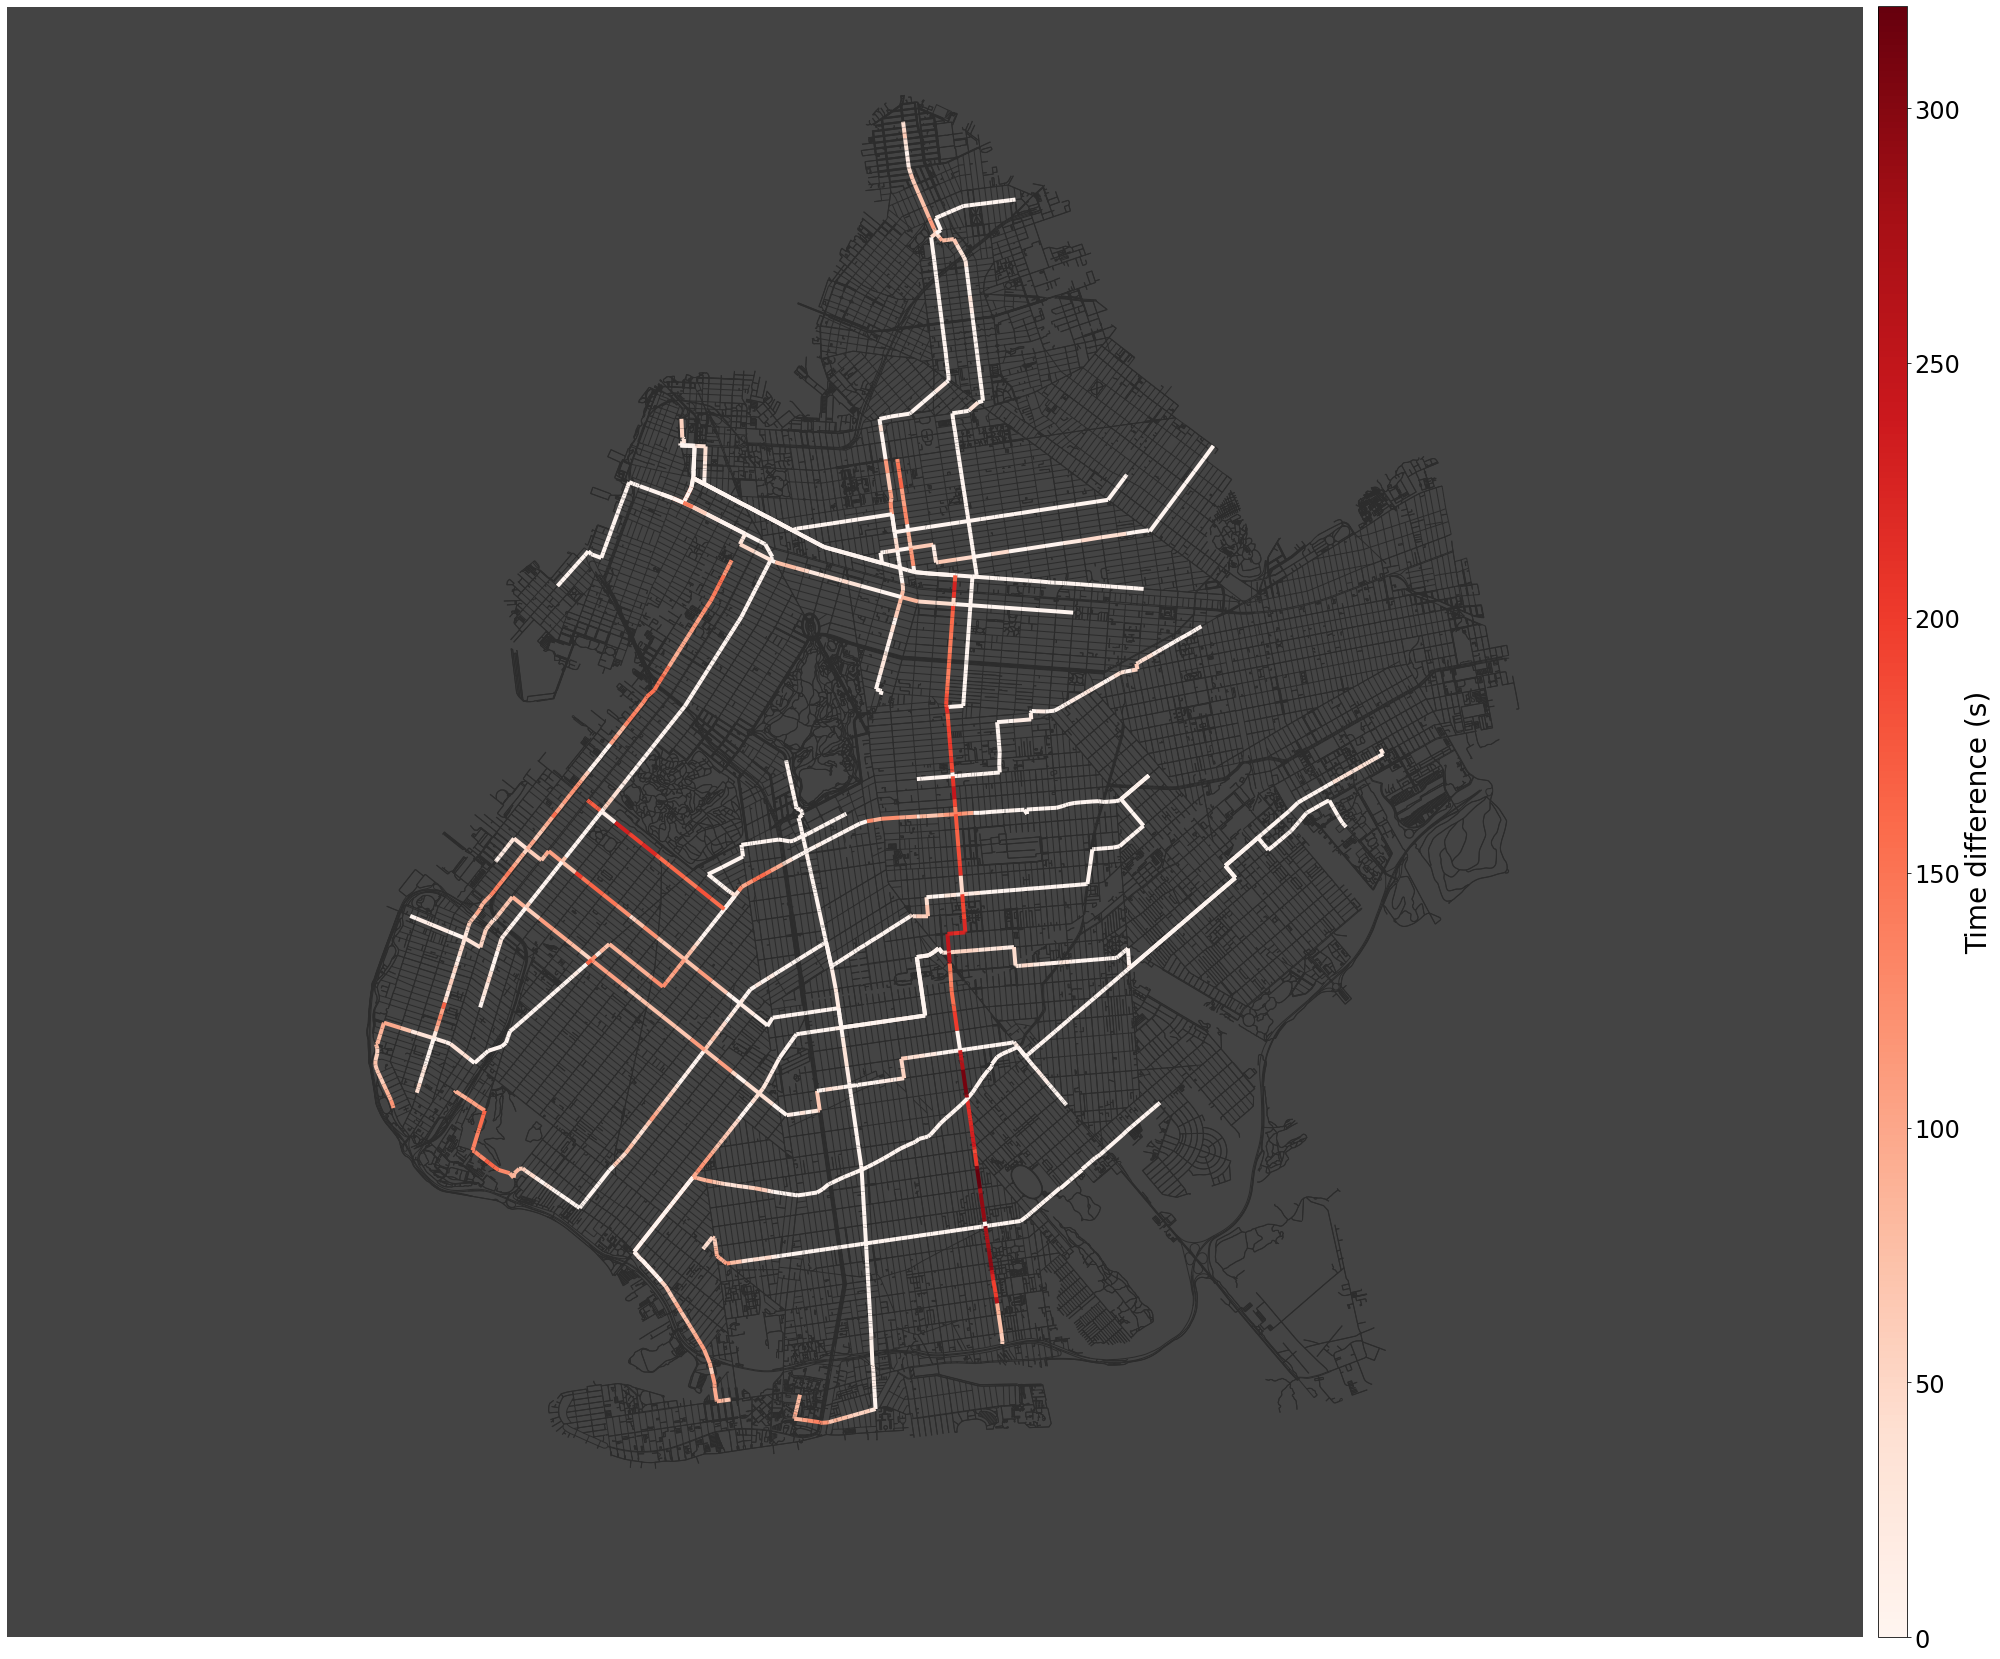

In [241]:
fig, ax = plt.subplots(figsize=(40, 30))
ox.plot_graph(bk,
              ax=ax,
              bgcolor='#444',
              node_size=0,
              show=False,
              close=False,
              edge_color='#2c2c2c')

edge_colors = ox.plot.get_edge_colors_by_attr(route_subgraph,
                                              attr='weight',
                                              cmap='Reds')
ox.plot_graph(route_subgraph,
              ax=ax,
              bgcolor='#444',
              node_size=0,
              bbox=bbox,
              show=False,
              close=False,
              edge_color=edge_colors,
              edge_linewidth=4)

import matplotlib as mpl
norm=plt.Normalize(vmin=0, vmax=abs(np.min(time_deltas)))
cbar_ax = fig.add_axes([0.84, 0.125, 0.01, .755])
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='Reds'), cax=cbar_ax, ax=ax, pad=0)
cb.ax.tick_params(labelsize=24) 
cb.set_label('Time difference (s)', fontsize=28, labelpad=5)

ax.set_facecolor('#444')

In [177]:
route_subgraph = create_route_subgraph(route_node_ids_list)

for edge in route_subgraph.edges:
    route_subgraph.add_edge(edge[0], edge[1], edge[2], weight=0)
    
time_deltas = []

for route_node_ids in route_node_ids_list:
    for i in range(0, len(route_node_ids) - 1):
        route_node_id = route_node_ids[i]
        next_node_id = route_node_ids[i + 1]
        if route_node_id not in diff_avg_df.index:
            continue
        if next_node_id not in diff_avg_df.index:
            continue
        time_delta = diff_avg_df.loc[route_node_id]
        time_deltas.append(time_delta)
        if time_delta > 0:
            time_delta = 0
        route_subgraph.add_edge(route_node_id, next_node_id, 0, weight=abs(time_delta))

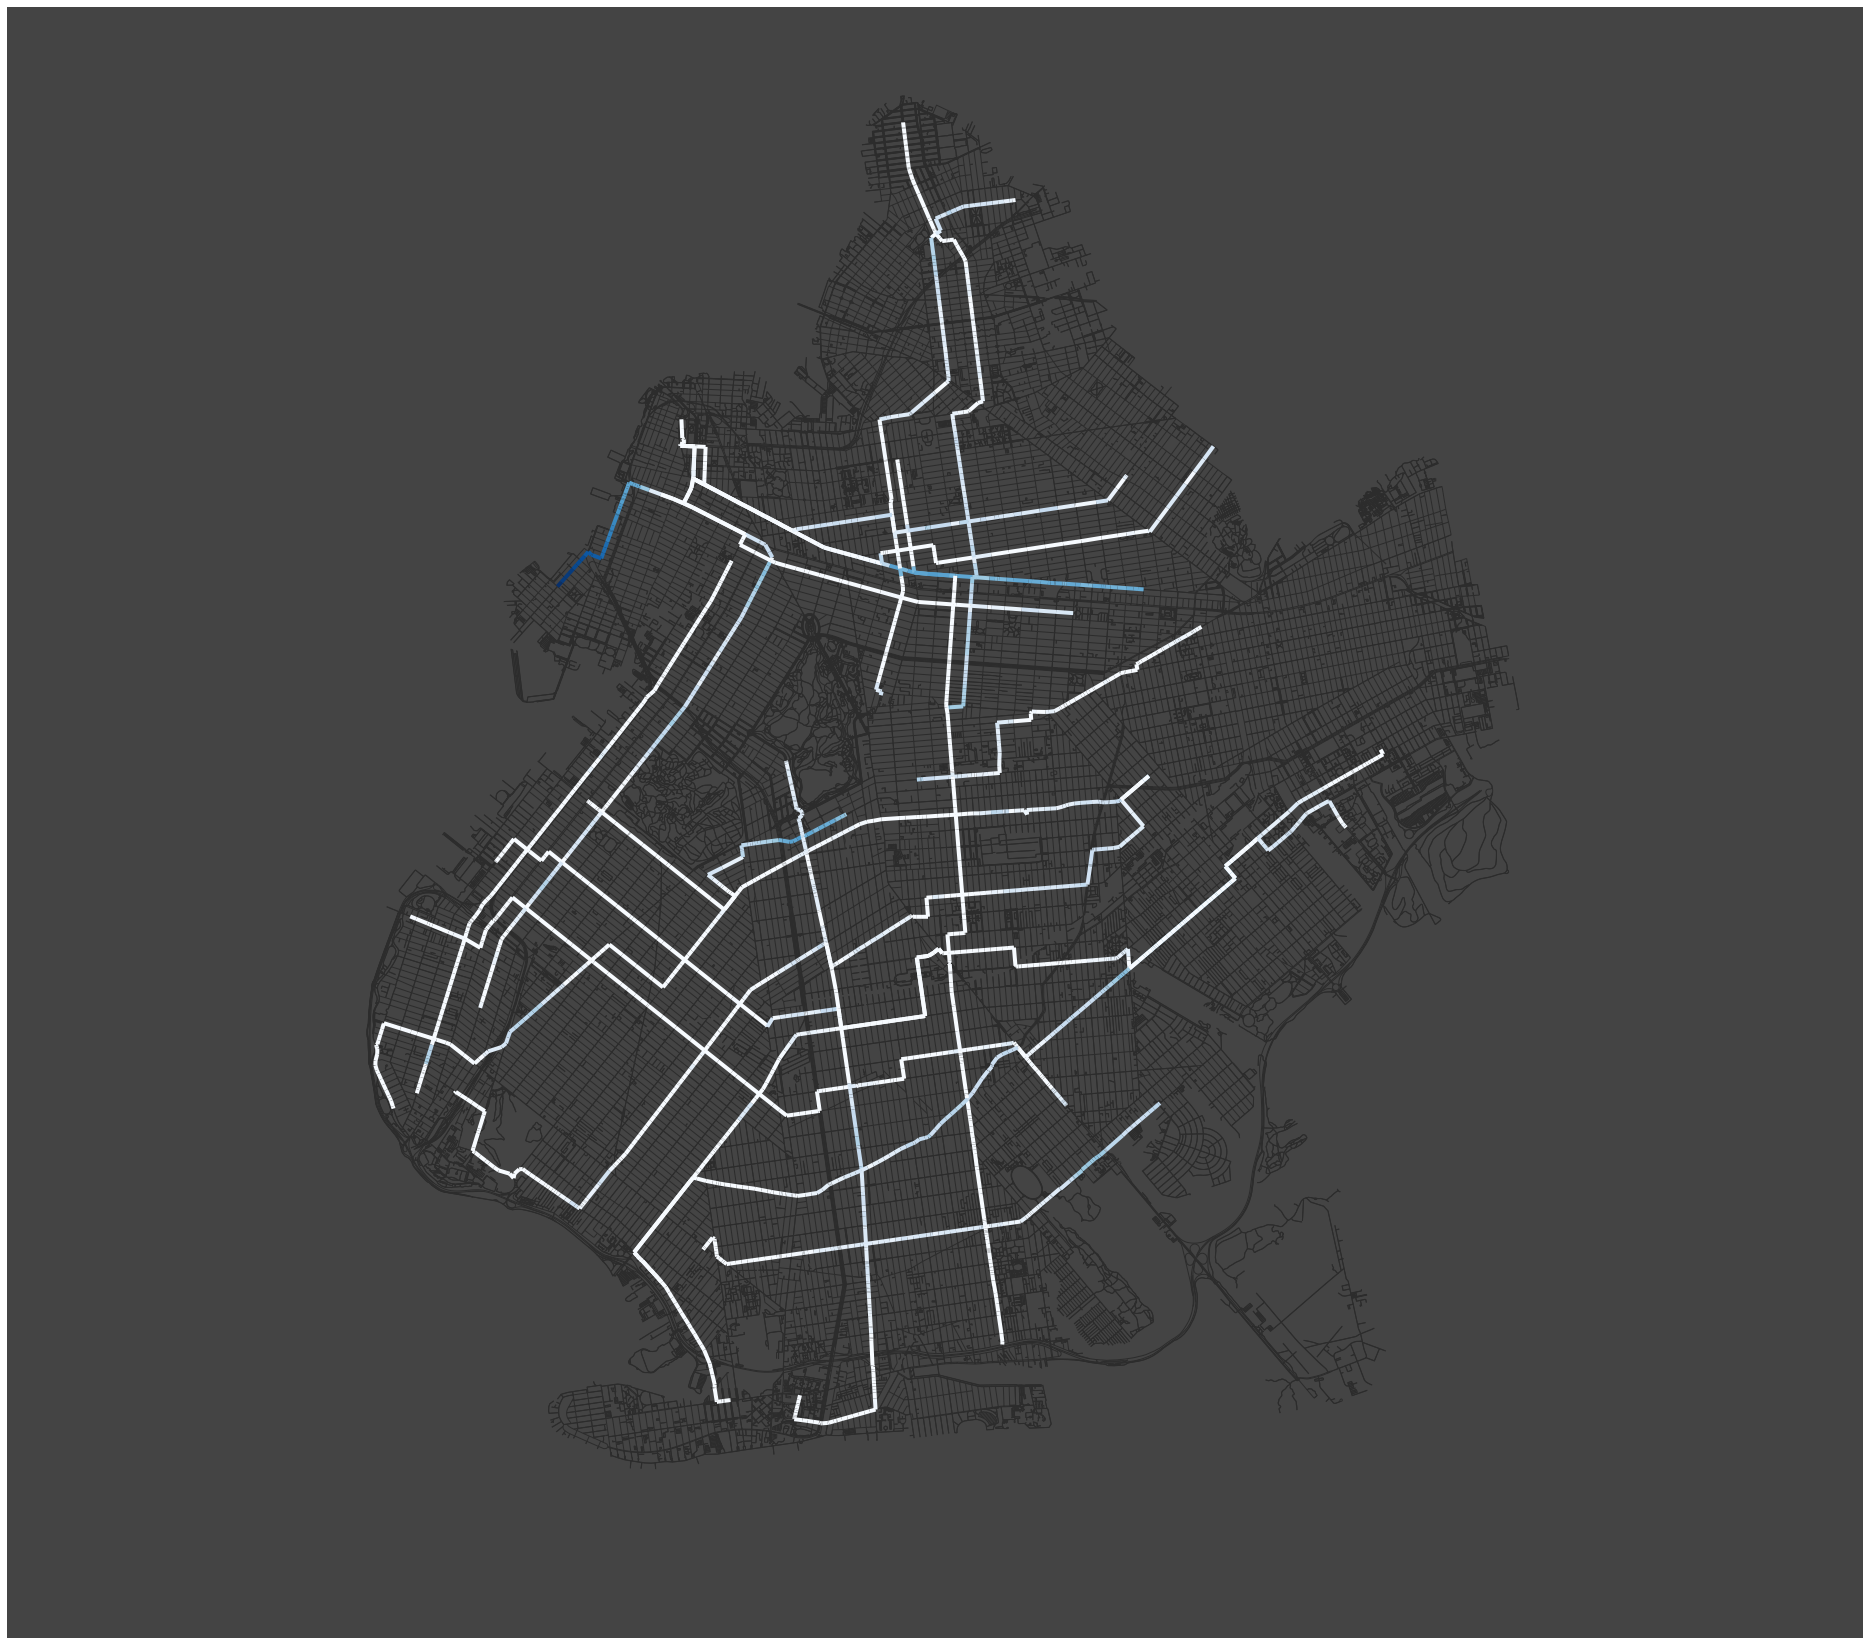

In [178]:
fig, ax = plt.subplots(figsize=(40, 30))
ox.plot_graph(bk, ax=ax, bgcolor='#444', node_size=0, show=False, close=False, edge_color='#2c2c2c')

edge_colors = ox.plot.get_edge_colors_by_attr(route_subgraph, attr='weight', cmap='Blues')
ox.plot_graph(route_subgraph, ax=ax, bgcolor='#444', node_size=0, bbox=bbox, show=False, close=False, edge_color=edge_colors, edge_linewidth=4)
ax.set_facecolor('#444')

In [179]:
route_subgraph = create_route_subgraph(route_node_ids_list)

for edge in route_subgraph.edges:
    route_subgraph.add_edge(edge[0], edge[1], edge[2], weight=0)
    
time_deltas = []

for route_node_ids in route_node_ids_list:
    for i in range(0, len(route_node_ids) - 1):
        route_node_id = route_node_ids[i]
        next_node_id = route_node_ids[i + 1]
        if route_node_id not in diff_avg_df.index:
            continue
        if next_node_id not in diff_avg_df.index:
            continue
        time_delta = diff_avg_df.loc[route_node_id]
        time_deltas.append(time_delta)
        route_subgraph.add_edge(route_node_id, next_node_id, 0, weight=time_delta)

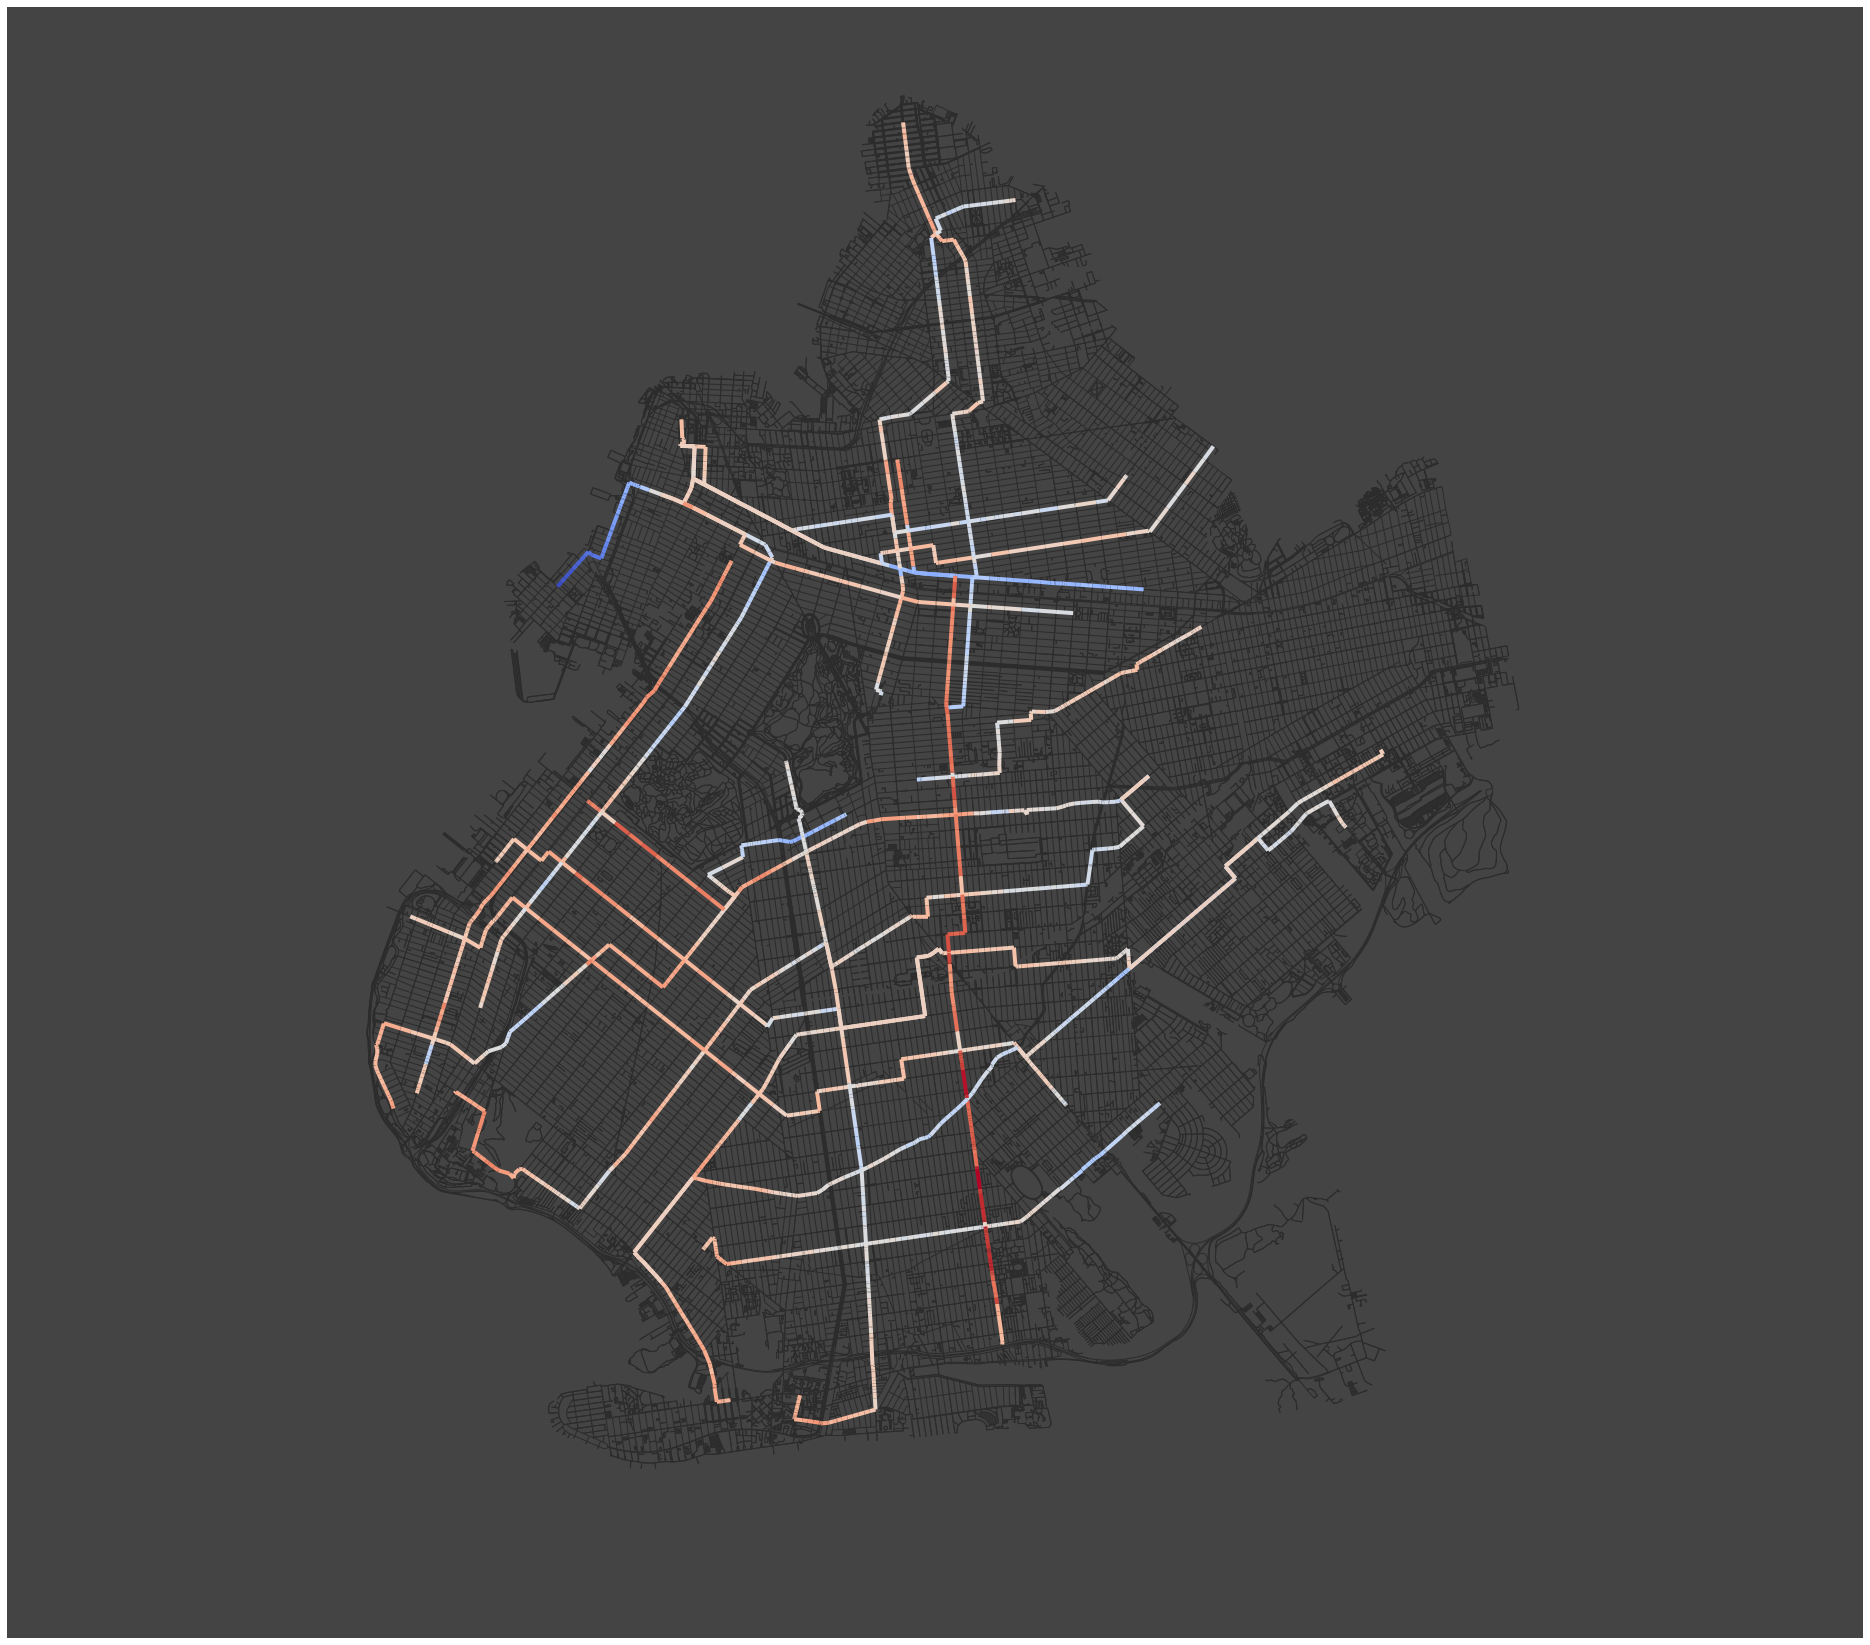

In [180]:
fig, ax = plt.subplots(figsize=(40, 30))
ox.plot_graph(bk, ax=ax, bgcolor='#444', node_size=0, show=False, close=False, edge_color='#2c2c2c')

edge_colors = ox.plot.get_edge_colors_by_attr(route_subgraph, attr='weight', cmap='coolwarm')
ox.plot_graph(route_subgraph, ax=ax, bgcolor='#444', node_size=0, bbox=bbox, show=False, close=False, edge_color=edge_colors, edge_linewidth=4)
ax.set_facecolor('#444')